# Sampling from a Sample

## Contents <a id='top'></a>

1. <a href=#intro>Introduction</a>
1. <a href=#generate>Generate Random Data</a>
1. <a href=#kde>Generate from Kernel Density Estimate</a>
1. <a href=#hist>Generate from Histogram</a>
1. <a href=#finv>Generate from $F^{-1}$</a>
1. <a href=#ref>References and Links</a>

## 1. Introduction     <a id='intro'></a>
<a href=#top>(back to top)</a>


The `samplers` module contains a set of functions for generating samples from a random i.i.d sample. The output random variates should have a similar distribution to the input sample.

The aim is different from bootstrapping, where we resample from the same values. Here, we will obtain from a smoother distribution.

The basic problem is this: We are given an i.i.d sample $X_1, X_2, .., X_n$ from a density $f$. We wish to generate $Y_1, Y_2, ... , Y_m$ from the same unknown density. This is a difficult problem, but some progress is possible.

A good, detailed exposition of the methods implemented here can be found in reference number 1.

These are the functions that are present in this module:

1. `rand_bartlett()`:
    + Generate random variates from Bartlett kernel. (a helper function used in rand_from_density())
2. `rand_from_density()`:
    + Generate new sample from a kernel density estimate.
3. `rand_from_hist()`:
    + Generate a new sample from a histogram estimate.
4. `rand_from_Finv()`:
    + Generate a new sample from an estimate of F-inverse.
    
On this manual page, we provide examples of how to call these samplers on their own. As part of `DirtyDF`, they are used within the stainers `ResidualResampler` and `ModifyCorrelation` stainer classes.

---

## 2. Generate Random Data    <a id='generate'></a>
<a href=#top>(back to top)</a>

The first step is to generate a sample of i.i.d data. After that, we shall use the functions in the `samplers` module to generate new random variates based on these. The following code loads all the modules that we will need.

In [3]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
%matplotlib inline

import ddf.samplers as samplers

The next code generates from a $\chi^2$ distribution with 10 degrees of freedom. This is a right-skewed distribution, with mean 10. Suppose that this sample is what we have to begin with.

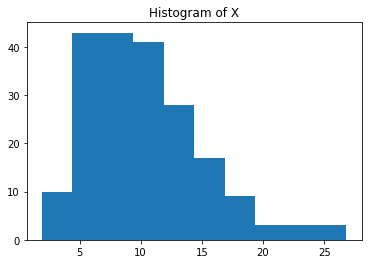

In [4]:
rng = default_rng(4590)
X = rng.chisquare(df=10, size=200)
plt.hist(X)
plt.title('Histogram of X');

---

## 3. Generate from Kernel Density Estimate     <a id='kde'></a>
<a href=#top>(back to top)</a>

`rand_from_density` uses a kernel density estimate from $X$ to generate new random variates. The kernel used to estimate the density is the Bartlett kernel, also sometimes known as the Epanechnikov kernel:

$$
K(x) = \frac{3}{4}(1- x^2)
$$

The support of this kernel is $-1 < x < 1$. The bandwidth used is [Scott's rule of thumb.](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.bandwidths.bw_scott.html?highlight=scott#statsmodels.nonparametric.bandwidths.bw_scott)

Bear in mind that the support of the estimated density might not match with the original distribution, so we have to sample from the conditional density. In this case, we only retain those values that fall within the desired support, as indicated by the `lower` and `upper` arguments of `rand_from_density`.

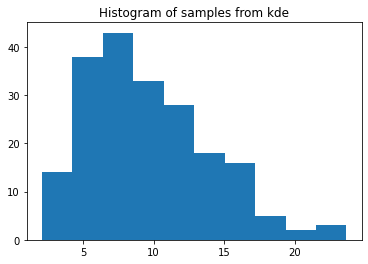

In [5]:
X_from_kde = samplers.rand_from_density(X, rng, size=200, lower=0.0)
plt.hist(X_from_kde)
plt.title('Histogram of samples from kde');

We can double-check that the minimum value of the new sample is non-negative:

In [6]:
X_from_kde.min()

2.0818114088283197

---

## 4. Generate from Histogram     <a id='hist'></a>
<a href=#top>(back to top)</a>

`rand_from_hist` uses a histogram of the original $X$ sample to generate a new sample. Bear in mind that this is even more subjective than using a kernel density, because histograms are very dependent on the number and width of bins used. Here, the Freedman-Diaconis method is used to estimate the bin widths.

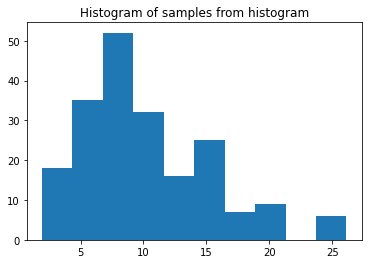

In [7]:
X_from_hist = samplers.rand_from_hist(X, rng, size=200)
plt.hist(X_from_hist)
plt.title('Histogram of samples from histogram');

---

## 5. Generate from F-inverse     <a id='finv'></a>
<a href=#top>(back to top)</a>

The final algorithm uses Akima's interpolation algorithm to interpolate the observed values to obtain a smooth function for the quantile function. At this point, generating samples is just a matter of generating $U(0,1)$ random variates and computing the quantile function values:

If we wish to generate $X \sim F$, then we only need to generate $U(0,1)$ and take $F^{-1}(U)$. (Probability Integral Transform)

Remember $F^{-1}:(0,1) \rightarrow \mathbf{R}$, but we cannot interpolate to unbounded limits, so we have to set where 0 and 1 map to. The defaults are to take the min and max observed values.


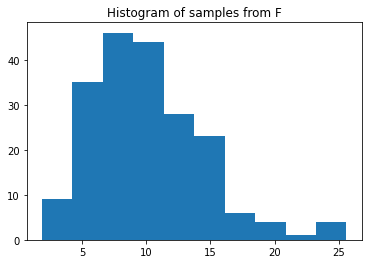

In [8]:
X_from_F = samplers.rand_from_Finv(X, rng, size=200)
plt.hist(X_from_F)
plt.title('Histogram of samples from F');

By default, the function returns new random variates. However, we might need to re-use the sampler. Hence we can choose to return the interpolated $F^{-1}$ for later use:

In [9]:
Finv = samplers.rand_from_Finv(X, rng, return_fn=True)
Finv(rng.random(size=5))

array([ 7.01401915, 11.5596572 ,  6.24697875, 10.40065283,  8.63261271])

---

Before we end, here is a side-by-side view of the output from the 3 algorithms, along with the original

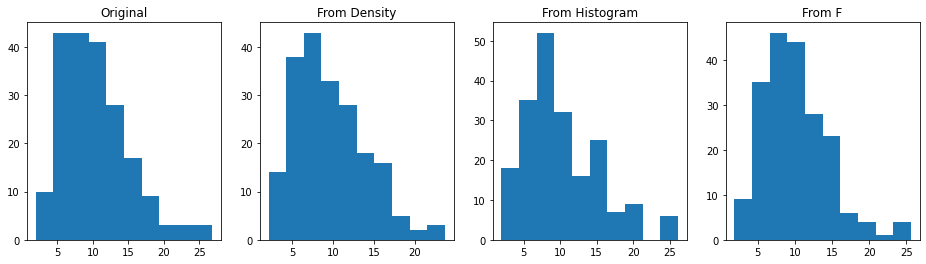

In [10]:
plt.subplots(1,4, figsize=(16,4))
plt.subplot(141)
plt.hist(X);
plt.title("Original");

plt.subplot(142)
plt.hist(X_from_kde);
plt.title("From Density");

plt.subplot(143)
plt.hist(X_from_hist);
plt.title("From Histogram");

plt.subplot(144)
plt.hist(X_from_F)
plt.title("From F");

# 6. References        <a id='ref'></a>
<a href=#top>(back to top)</a>

1. *A new method of interpolation and smooth curve fitting based on local procedures*, H Akima (1970).
2. *A random number generator for continuous random variables*, Guerra et al. (1972).
3. *Sample-based Non-uniform Random Variate Generation*, Luc Devroye (1986).
4. *Non-uniform Random Variate Generation*, Luc Devroye (1986).
5. *Simulation*, Sheldon Ross (2012).